# School mode choice model k-12 students

Estimate mode choice for school ralated trips

To improve: 
- Verify trips tables
- Check students with school ID table

In [1]:
import numpy as np
import pandas as pd
import orca
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import os; os.chdir('../../')
import warnings; warnings.simplefilter('ignore')

import pandana as pdna
from collections import OrderedDict
import pylogit as pl
from pylogit import nested_logit as nl
import math 
import pickle
import dill
import time
import random
import scipy.stats as st
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
    
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim.utils import misc
import urbansim_templates

from scripts import datasources, models, variables, utils

Registering model step 'auto_ownership'
Registering model step 'WLCM_gen_tt'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [2]:
input_file_format = 'csv'
input_data_dir = '/home/data/spring_2019/base/'

formattable_fname_dict = {
    'parcels': 'parcels.{0}',
    'buildings': 'buildings.{0}',
    'jobs': 'jobs.{0}',
    'establishments': 'establishments.{0}',
    'households': 'households.{0}',
    'persons': 'persons.{0}',
    'rentals': 'craigslist.{0}',
    'units': 'units.{0}',
    'mtc_skims': 'mtc_skims.{0}',
    'beam_skims_raw': '30.skims-smart-23April2019-baseline.csv.gz',
    'beam_skims_imputed': 'beam_skims_imputed.{0}',
    # the following nodes and edges .csv's will be phased out and
    # replaced by travel model skims entirely
    'drive_nodes': 'drive_nodes.{0}',
    'drive_edges': 'drive_edges.{0}',
    'drive_access_vars': 'drive_net_vars.{0}',
    'walk_nodes': 'walk_nodes.{0}',
    'walk_edges': 'walk_edges.{0}',
    'walk_access_vars': 'walk_net_vars.{0}',
    'zones': 'zones.{0}',
    'zone_access_vars': 'zones_w_access_vars.{0}',
}

def format_fname_dict(formattable_fname_dict, format='csv'):
    formatted_dict = {
        k: v.format('csv')
        for k, v in formattable_fname_dict.items()}
    return formatted_dict

input_fnames = format_fname_dict(
            formattable_fname_dict, input_file_format)

In [3]:
orca.add_injectable('input_file_format', input_file_format)
orca.add_injectable('input_data_dir', input_data_dir)
orca.add_injectable('input_fnames', input_fnames)
orca.add_injectable('store', None)

In [4]:
orca.run(['initialize_network_small']) 
orca.run([ 'initialize_network_walk']) 
orca.run(['initialize_imputed_skims']) 
orca.run(['skims_aggregations']) 

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s
Running step 'initialize_imputed_skims'
No imputed skims found. Creating them now.
Time to execute step 'initialize_imputed_skims': 89.01 s
Total time to execute iteration 1 with iteration value None: 89.01 s
Running step 'skims_aggregations'
Time to execute step 'skims_aggregations': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


## Loading data

In [ ]:
trips = pd.read_csv('/home/emma/ual_model_workspace/spring-2019-models/notebooks-emma/HStrips_031219.csv', index_col = 0)
students = pd.read_csv('/home/juan/ual_model_workspace/spring-2019-models/notebooks-juan/students_with_school_id.csv')
persons = pd.read_csv('/home/data/fall_2018/chts_persons_w_zone_ids.csv')
households = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")
zones = orca.get_table('zones').to_frame()
beam_skims = orca.get_table('beam_skims_imputed').to_frame().reset_index()
schools = orca.get_table('schools').to_frame()

## Data merging

- Merges students, households and time-based accesibility variables
- Merges travel time and travel cost (beam skims) 

In [22]:
#select people who make both home-school and school-home trips:
tripsII = trips.groupby('HHPER').filter(lambda x: len(x) == 2)

tripsIII = tripsII.sort_values(['HHPER','origin'])

#move school-home trip info up into home-school trip rows
tripsIII['school_dwell'] = tripsIII.groupby('HHPER', group_keys=False).origin_dwell.shift(-1)
tripsIII['school_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ST.shift(-1)
tripsIII['SH_trip_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ET.shift(-1)
tripsIII['SH_trip_ET'] = tripsIII.groupby('HHPER', group_keys=False).trip_ET.shift(-1)
tripsIII['SH_TT'] = tripsIII.groupby('HHPER', group_keys=False).TT.shift(-1)
tripsIII['SH_mode'] = tripsIII.groupby('HHPER', group_keys=False).MODE.shift(-1)

tripsIII = tripsIII.groupby('HHPER').first().reset_index()

tripsIII.rename(columns = {'origin_dwell':'home_dwell',
                           'origin_ST':'home_ST',
                           'origin_ET':'HS_trip_ST',
                           'trip_ET':'HS_trip_ET',
                           'TT':'HS_TT',
                           'MODE':'HS_mode',
                           'TOD':'HS_TOD'},
                inplace = True)

tripsIII['SAMPN'] = [ str(x)[:-1] for x in tripsIII.HHPER]
tripsIII['SAMPN'] = tripsIII['SAMPN'].astype(int)

tripsIII['PERNO'] = [ str(x)[-1:] for x in tripsIII.HHPER]
tripsIII['PERNO'] = tripsIII['PERNO'].astype(int)

# % HS and SH trips in the same mode. 
(tripsIII.HS_mode == tripsIII.SH_mode).sum()/len(tripsIII)*100

87.70416962564674

In [23]:
#Students data
# students = persons.loc[persons['STUDE'].isin([1, 2])# full time & part time students
#                  & persons['SCHOL'].isin([3,  # Kindergarten to grade 8
#                                           4])  # Grades 9 to 12 
#                  & (~persons['SNAME_lookup'].isna()) 
#                  & (persons['SNAME_lookup'] != "DK/RF")]

# students['HHPER'] = (students['SAMPN'].map(str) + students['PERNO'].map(str)).astype(int)
students = pd.read_csv('/home/juan/ual_model_workspace/spring-2019-models/notebooks-juan/students_with_school_id.csv')

not_include = ['WNAME_lookup', 'WCITY_lookup', 'WZIP_lookup',
       'WXST1_lookup', 'WXST2_lookup', 'WXCORD_lookup', 'WYCORD_lookup',
       'WNAME2_lookup', 'WCITY2_lookup', 'WZIP2_lookup', 'WXST2_1_lookup',
       'WXST2_2_lookup', 'SNAME_lookup', 'SCITY_lookup', 'SZIP_lookup',
       'SXST1_lookup', 'SXST2_lookup', 'SXCORD_lookup', 'SYCORD_lookup',
       'WCTFIP_lookup', 'WTRACT_lookup', 'WBLOCK', 'WPrimaryCity_lookup',
       'WSTFIP_lookup', 'W2PrimaryCity_lookup', 'W2STFIP_lookup',
       'SCTFIP_lookup', 'STRACT_lookup', 'SBLOCK', 'SPrimaryCity_lookup',
       'SSTFIP_lookup', 'HCITY', 'HZIP', 'HXCORD', 'HYCORD', 'HBLOCK',
       'HTRACT', 'HCTFIP', 'HPrimaryCity', 'parcel_id_home', 'parcel_id_work',
       'zone_id_work', 'Unnamed: 0', 'index']

students = students.drop(columns=not_include)

#Merging race columns to just 1 (consistent with PUMPS race classification)
students['race'] = students.RACE1.notnull().astype(int) + \
                          students.RACE2.notnull().astype(int) + \
                          students.RACE3.notnull().astype(int) + \
                          students.RACE4.notnull().astype(int)

students['race'] = students['race'].replace(2, 6) # Two or more races (6. 2+ races)
students['race'] = np.where(students['race'] == 1, students['RACE1'], students['race'])

#Merging trip and students to select K-12 students
tripsIV = tripsIII.merge(students, how = 'left', on = ['SAMPN', 'PERNO'])

#Age cleaning
tripsIV.AGE.replace([998, 999, 99], np.nan, inplace = True) #NAN values CHTS documentation
tripsIV = tripsIV[tripsIV.AGE <= 18] #Filtering students older than 18 years (only 3)
tripsIV.dropna(subset=['AGE'], inplace = True)

################################################################################
################################################################################
## CHECK THIS MERGE ONLY HAS 53% OF STUDENTS.. THERE ARE SOME MISSING TRIPS ####
################################################################################
tripsIV.AGE.notnull().sum()

1792

In [24]:
#Merging household attributes
tripsV = tripsIV.merge(households, how = 'left', on = 'SAMPN')

In [25]:
# Merging zones
tripsVI = tripsV.merge(zones, how = 'left', left_on ='zone_id_home', right_index = True )

In [26]:
#Merging schools
tripsVII = tripsVI.merge(schools, how = 'left', left_on = 'school_id', right_index = True)

In [27]:
#Merging travel time and travel zones
tripsVIII = tripsVII.merge(beam_skims, 
                        how = 'left', 
                        left_on = ['zone_id_home','school_zone_id'], 
                        right_on = ['from_zone_id','to_zone_id'])

In [28]:
###############
#Merging additional hosuehold attributes based on the persons table 
##########################################

#Getting number of children per household, race and age of the head (head assume to be PERNO == 1)
persons['children'] = (persons.AGE < 18).astype(int) # Children indicator
# persons.loc[:,['RACE1', 'RACE2', 'RACE3', 'RACE4', 'O_RACE']]
persons['race_id'] = persons.RACE1.notnull().astype(int) + \
                          persons.RACE2.notnull().astype(int) + \
                          persons.RACE3.notnull().astype(int) + \
                          persons.RACE4.notnull().astype(int)

persons['race_id'] = persons['race_id'].replace(2, 6) # Two or more races (6. 2+ races)
persons['race_id'] = np.where(persons['race_id'] == 1, persons['RACE1'], persons['race_id'])


hh_per_var = persons.loc[:,['SAMPN', 'PERNO', 'children','race_id', 'AGE', 'HISP']].sort_values(['SAMPN', 'PERNO']).groupby('SAMPN').\
             agg({'children': 'sum', 'race_id': 'first', 'AGE': 'first', 'HISP': 'first'})

hh_per_var.rename(columns = {'AGE': 'age_of_head', 'race_id': 'race_head', 'HISP': 'hispanic_head'}, inplace = True)

tripsIX = tripsVIII.merge(hh_per_var, how = 'left', left_on = 'SAMPN', right_index = True )



In [29]:
df_trips = tripsIX
df_trips.shape

(1792, 350)

## Data preparation

In [30]:
 #adding recent mover varible
df_trips['recent_mover'] = (df_trips.TEN <= 5).astype(int)

#Naming varaibles as in PUMS varaibles
pums_names = {'HHSIZ': 'persons', 'INCOM': 'income', 'OWN': 'tenure', 'HHVEH': 'cars', 'HHEMP': 'workers', 
              'AGE': 'age', 'SCHOL': 'education', 'GEND': 'sex', 'HISP': 'hispanic', 'HS_trip_ET': 'HS_ET'}

df_trips.rename(columns=pums_names, inplace = True)

# Replacing na keys to real na's
na_dict = {
    'race':[98, 99],
    'hispanic':[8, 9],
    'sex':[9],
    'income':[98,99],
    'tenure':[7, 8, 9],
    'race_head':[98, 99],
    'hispanic_head':[8, 9],
    'age_of_head': [998, 999],
    }

for col in na_dict:
    for vals in na_dict[col]:
        df_trips[col] = df_trips[col].replace(vals,np.nan)

df_trips.shape

(1792, 351)

In [31]:
## Preparing data for ML models

# Replacing mode string categories with number categories
df_trips['trip_mode'] = df_trips['HS_mode'].replace(['drive_alone', 
                                                     'shared', 'walk', 
                                                     'bike', 'WTranW', 
                                                     'DrTranW', 'WSBusW'],
                                                    [1,2,3,4,5,6,7])

#Race dictionary
race_dict = {1.0 :'white', 2.0 : 'african_american', 3.0 : 'indian/alaska', 
             4.0 : 'asian', 5.0 : 'hawaii/pacific', 6.0 : '2+races', 97.0 : 'other'}

#Replace race with values in race dictionary
df_trips.race.replace(race_dict, inplace = True)
df_trips.race_head.replace(race_dict, inplace = True)

# Dummy variables
df_trips.education.replace([3.0, 4.0], [0, 1], inplace = True) # 0:k-8, 1:9-12
df_trips.hispanic.replace([1.0, 2.0], [1, 0], inplace = True) # 0:non-hispanic, 1:hispanic
df_trips.sex.replace([1.0, 2.0], [0, 1], inplace = True) # 0:male, 1:female
df_trips.tenure.replace([1.0, 2.0], [0, 1], inplace = True) # 0:own_house, 1:rent_house
df_trips.tenure.replace([1.0, 2.0], [0, 1], inplace = True) # 0:own_house, 1:rent_house
df_trips.hispanic_head.replace([1.0, 2.0], [1, 0], inplace = True) # 0:non-hispanic, 1:hispanic
df_trips.type.replace(['public', 'private'], [0, 1], inplace = True) # 0:public school, 1:private school

#One hot enconde race variables
race_dummies = pd.get_dummies(df_trips.race, prefix = 'race')
head_race_dummies = pd.get_dummies(df_trips.race_head, prefix = 'race_head')

#Concatenate one hot encoded dataframes
df = pd.concat([df_trips,race_dummies, head_race_dummies], axis = 1)
df.shape

(1792, 366)

In [32]:
#Vars names
time_acc = list(set(zones.columns) - {'acres', 'area', 'gid'})
beam_var = list(set(beam_skims.columns) - {'from_zone_id', 'to_zone_id'})

#Categorical varaibles
cat_var = ['sex', 'tenure' , 'recent_mover',
           'hispanic_head','income'] + list(race_dummies.columns) + list(head_race_dummies.columns)

#Continous variables 
cont_vars = ['age', 'persons', 'cars', 'workers', 'children', 'age_of_head', 'HS_ET'] + time_acc + beam_var

total_vars = cat_var + cont_vars + ['trip_mode']
df = df.loc[:,total_vars + ['HHPER', 'SAMPN', 'PERNO', 'HS_TT']]

# Dropping na's
print ('Observation before dropping na = ' + str(df.shape[0]))
df.dropna(inplace = True)
print ('Observation after dropping na = ' + str(df.shape[0]))

Observation before dropping na = 1792
Observation after dropping na = 1656


['gen_cost_WALK_TRANSIT',
 'gen_tt_BIKE',
 'gen_tt_CAR',
 'gen_cost_DRIVE_TRANSIT',
 'gen_tt_RIDE_HAIL_TRANSIT',
 'gen_tt_WALK_TRANSIT',
 'gen_tt_RIDE_HAIL_POOLED',
 'gen_cost_RIDE_HAIL',
 'gen_cost_RIDE_HAIL_TRANSIT',
 'dist',
 'gen_cost_WALK',
 'gen_tt_DRIVE_TRANSIT',
 'gen_tt_RIDE_HAIL',
 'gen_cost_RIDE_HAIL_POOLED',
 'gen_cost_BIKE',
 'gen_tt_WALK',
 'gen_cost_CAR']

In [34]:
# df['walk_time_minutes'] = df.HS_TT * 60
# df['dif_beam_chts'] = np.abs(df.gen_tt_WALK - df.walk_time_minutes)
# walk_matrix = df[df.trip_mode == 3][['SAMPN','gen_tt_WALK','walk_time_minutes','dif_beam_chts', 'HS_TT']]

# walk_matrix.sort_values(by = ['dif_beam_chts'], ascending = False)[walk_matrix.dif_beam_chts > 30]

# plt.hist(walk_matrix.dif_beam_chts, bins = 30)

## ML Approach

In [85]:
#Splitting train and test data

vars_order = ['sex', 'tenure', 'recent_mover', 'hispanic_head', 'income',
       'race_2+races', 'race_african_american', 'race_asian',
       'race_hawaii/pacific', 'race_indian/alaska', 'race_other', 'race_white',
       'race_head_2+races', 'race_head_african_american', 'race_head_asian',
       'race_head_hawaii/pacific', 'race_head_indian/alaska',
       'race_head_other', 'race_head_white', 'age', 'persons', 'cars',
       'workers', 'children', 'age_of_head', 'HS_ET',
       'total_jobs_gen_tt_CAR_15', 'sum_income_gen_tt_CAR_45',
       'sum_income_gen_tt_WALK_TRANSIT_45',
       'sum_residential_units_gen_tt_WALK_TRANSIT_45', 'sum_income',
       'total_jobs_gen_tt_WALK_TRANSIT_45', 'sum_persons',
       'sum_residential_units_gen_tt_CAR_15', 'avg_income_gen_tt_CAR_30',
       'sum_income_gen_tt_CAR_15', 'sum_persons_gen_tt_WALK_TRANSIT_15',
       'sum_residential_units_gen_tt_CAR_45',
       'sum_persons_gen_tt_WALK_TRANSIT_45', 'sum_persons_gen_tt_CAR_15',
       'sum_residential_units', 'avg_income_gen_tt_WALK_TRANSIT_30',
       'sum_persons_gen_tt_CAR_45', 'total_jobs_gen_tt_WALK_TRANSIT_15',
       'sum_residential_units_gen_tt_WALK_TRANSIT_15',
       'sum_income_gen_tt_WALK_TRANSIT_15', 'total_jobs', 'avg_income',
       'total_jobs_gen_tt_CAR_45', 'gen_cost_WALK_TRANSIT', 'gen_tt_BIKE',
       'gen_tt_CAR', 'gen_cost_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL_TRANSIT',
       'gen_tt_WALK_TRANSIT', 'gen_tt_RIDE_HAIL_POOLED', 'gen_cost_RIDE_HAIL',
       'gen_cost_RIDE_HAIL_TRANSIT', 'dist', 'gen_cost_WALK',
       'gen_tt_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL', 'gen_cost_RIDE_HAIL_POOLED',
       'gen_cost_BIKE', 'gen_tt_WALK', 'gen_cost_CAR']


X = df[['gen_cost_WALK_TRANSIT', 'gen_tt_BIKE',
       'gen_tt_CAR', 'gen_cost_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL_TRANSIT',
       'gen_tt_WALK_TRANSIT', 'gen_tt_RIDE_HAIL_POOLED', 'gen_cost_RIDE_HAIL',
       'gen_cost_RIDE_HAIL_TRANSIT', 'dist', 'gen_cost_WALK',
       'gen_tt_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL', 'gen_cost_RIDE_HAIL_POOLED',
       'gen_cost_BIKE', 'gen_tt_WALK', 'gen_cost_CAR']]
y = df.trip_mode
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
X_train.columns

Index(['gen_cost_WALK_TRANSIT', 'gen_tt_BIKE', 'gen_tt_CAR',
       'gen_cost_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL_TRANSIT',
       'gen_tt_WALK_TRANSIT', 'gen_tt_RIDE_HAIL_POOLED', 'gen_cost_RIDE_HAIL',
       'gen_cost_RIDE_HAIL_TRANSIT', 'dist', 'gen_cost_WALK',
       'gen_tt_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL', 'gen_cost_RIDE_HAIL_POOLED',
       'gen_cost_BIKE', 'gen_tt_WALK', 'gen_cost_CAR'],
      dtype='object')

In [87]:
# #Normalazing training data
# scaler = StandardScaler()
# column_names_to_normalize = cont_vars
# x = X_train[column_names_to_normalize]
# x_scaled = scaler.fit_transform(x)
# df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = X_train.index)
# X_train_nor = pd.concat([X_train[cat_var], df_temp], axis = 1)
X_train_nor = X_train

# #Normalazig test data
# x_test = X_test[column_names_to_normalize]
# x_test_scaled = scaler.transform(x_test)
# df_temp = pd.DataFrame(x_test_scaled, columns=column_names_to_normalize, index = X_test.index)
# X_test_nor = pd.concat([X_test[cat_var], df_temp], axis = 1)
X_test_nor = X_test

In [88]:
X_train_nor.columns

Index(['gen_cost_WALK_TRANSIT', 'gen_tt_BIKE', 'gen_tt_CAR',
       'gen_cost_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL_TRANSIT',
       'gen_tt_WALK_TRANSIT', 'gen_tt_RIDE_HAIL_POOLED', 'gen_cost_RIDE_HAIL',
       'gen_cost_RIDE_HAIL_TRANSIT', 'dist', 'gen_cost_WALK',
       'gen_tt_DRIVE_TRANSIT', 'gen_tt_RIDE_HAIL', 'gen_cost_RIDE_HAIL_POOLED',
       'gen_cost_BIKE', 'gen_tt_WALK', 'gen_cost_CAR'],
      dtype='object')

### Decision tree

In [24]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train_nor, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

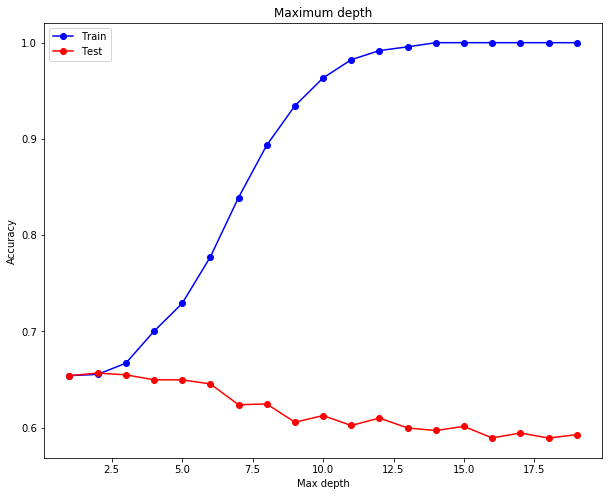

In [25]:
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

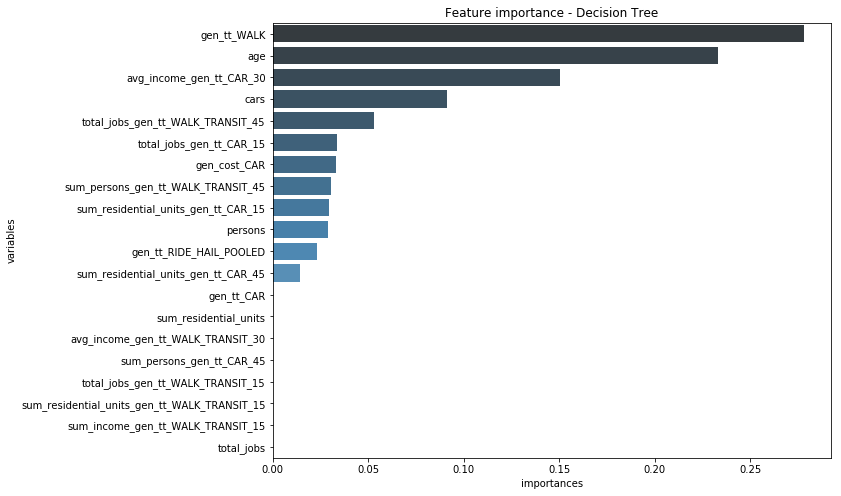

In [43]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
clf.fit(X_train_nor, y_train);

aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train_nor.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=aa[:20],palette="Blues_d" )
plt.title('Feature importance - Decision Tree');

# aa[:20].plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
# plt.yticks();#(fontsize = 10)
# # plt.tight_layout()

In [44]:
pd.crosstab( y_test, clf.predict(X_test_nor))#,normalize = 'index')

col_0,1,2,3
trip_mode,,,
1,17,10,0
2,9,301,11
3,0,88,11
4,0,21,2
5,0,11,0
6,0,2,0
7,1,13,0


In [45]:
clf.score(X_test_nor, y_test)

0.6619718309859155

### Gradient boosting

In [46]:
X_train_nor.columns

Index(['sex', 'tenure', 'recent_mover', 'hispanic_head', 'income',
       'race_2+races', 'race_african_american', 'race_asian',
       'race_hawaii/pacific', 'race_indian/alaska', 'race_other', 'race_white',
       'race_head_2+races', 'race_head_african_american', 'race_head_asian',
       'race_head_hawaii/pacific', 'race_head_indian/alaska',
       'race_head_other', 'race_head_white', 'age', 'persons', 'cars',
       'workers', 'children', 'age_of_head', 'HS_ET',
       'total_jobs_gen_tt_CAR_15', 'sum_income_gen_tt_CAR_45',
       'sum_income_gen_tt_WALK_TRANSIT_45',
       'sum_residential_units_gen_tt_WALK_TRANSIT_45', 'sum_income',
       'total_jobs_gen_tt_WALK_TRANSIT_45', 'sum_persons',
       'sum_residential_units_gen_tt_CAR_15', 'avg_income_gen_tt_CAR_30',
       'sum_income_gen_tt_CAR_15', 'sum_persons_gen_tt_WALK_TRANSIT_15',
       'sum_residential_units_gen_tt_CAR_45',
       'sum_persons_gen_tt_WALK_TRANSIT_45', 'sum_persons_gen_tt_CAR_15',
       'sum_residential_u

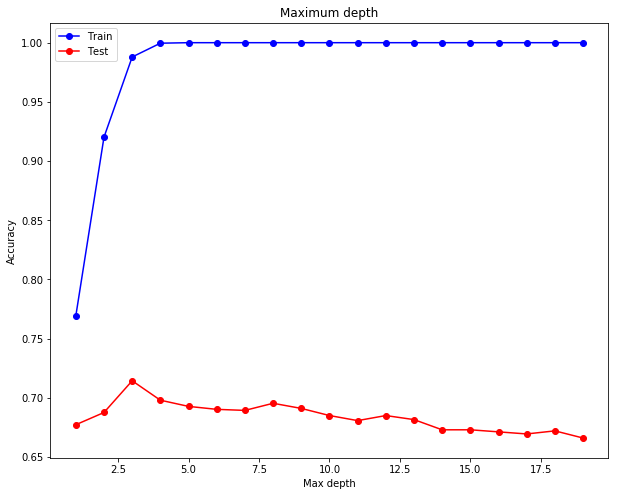

In [30]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = GradientBoostingClassifier(max_depth = i, n_estimators = 100)
    scores = cross_validate(clf, X_train_nor, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

In [31]:
X_train_nor

,sex,tenure,recent_mover,hispanic_head,income,race_2+races,race_african_american,race_asian,race_hawaii/pacific,race_indian/alaska,...,gen_tt_RIDE_HAIL_POOLED,gen_tt_WALK_TRANSIT,gen_tt_WALK,gen_cost_DRIVE_TRANSIT,gen_tt_RIDE_HAIL,gen_cost_RIDE_HAIL_POOLED,dist,gen_cost_WALK_TRANSIT,gen_tt_RIDE_HAIL_TRANSIT,gen_cost_WALK
188,0.0,0.0,0,0.0,8.0,1,0,0,0,0,...,2.149148,102.706749,30.280196,1.299095,2.765920,2.818466,1721.9938,98.328152,2.439422,254.222399
603,0.0,0.0,1,0.0,7.0,0,0,0,0,0,...,9.058559,432.904147,127.629612,5.475624,11.658224,11.879703,7258.1234,414.448566,10.282048,1071.535530
699,0.0,0.0,1,0.0,5.0,0,0,0,0,0,...,21.350882,1020.348354,300.821014,12.905960,27.478254,28.000276,17107.2842,976.848837,24.234627,2525.592613
874,0.0,0.0,0,0.0,10.0,0,0,0,0,0,...,3.294021,27.933333,46.410768,1.991136,4.239354,4.319892,2639.3176,11.183519,3.738926,389.649284
1400,0.0,0.0,0,0.0,8.0,0,0,0,0,1,...,22.880000,868.687921,256.108201,10.987671,23.393998,15.689924,14564.5270,831.653996,20.632490,2150.198791
18,1.0,0.0,0,0.0,7.0,0,0,1,0,0,...,0.964104,46.074056,13.583639,0.582771,1.240787,1.264359,772.4832,44.109825,1.094320,114.043693
465,0.0,0.0,1,0.0,8.0,0,0,0,0,0,...,3.093166,147.820928,43.580843,1.869725,3.980857,4.056484,2478.3836,141.519022,3.510943,365.890181
1196,0.0,0.0,0,1.0,5.0,0,0,0,0,0,...,1.345728,64.311702,18.960497,0.813452,1.731931,1.764834,1078.2578,61.569964,1.527488,159.185988
304,0.0,0.0,0,0.0,2.0,0,0,1,0,0,...,1.426070,68.151207,20.092467,0.862016,1.835330,1.870197,1142.6314,65.245783,1.618682,168.689629
1422,1.0,0.0,0,0.0,7.0,0,0,0,0,1,...,5.202143,248.607924,73.295054,3.144538,6.695078,6.822269,4168.1906,238.009265,5.904768,615.360759


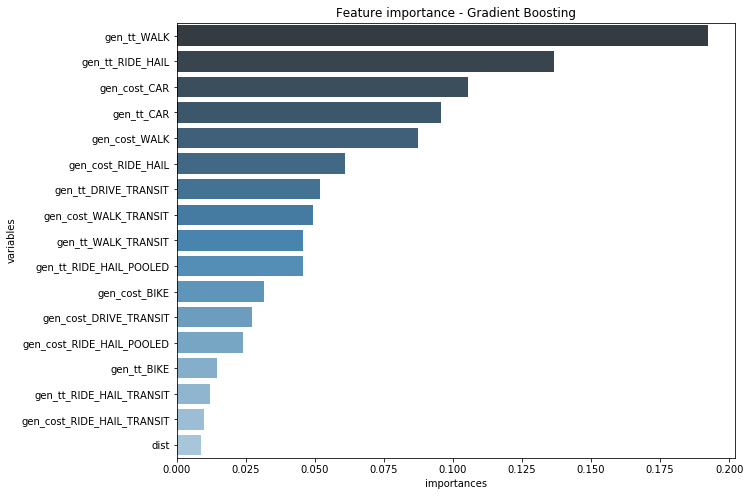

In [89]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train_nor, y_train)

# importances = model.feature_importances_
# pd.crosstab( y_test, model.predict(X_test))
# model.score(X_test, y_test)

feat_importance = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train_nor.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=feat_importance[:20],palette="Blues_d" )
plt.title('Feature importance - Gradient Boosting');

In [90]:
pd.crosstab( y_test, model.predict(X_test_nor))

col_0,1,2,3,4,5,6,7
trip_mode,,,,,,,
1,0,26,0,1,0,0,0
2,9,280,24,2,3,0,3
3,0,57,41,1,0,0,0
4,0,17,4,1,0,1,0
5,0,10,0,0,1,0,0
6,0,1,0,0,0,1,0
7,0,11,0,0,1,0,2


In [91]:
model.score(X_test_nor, y_test)

0.6559356136820925

In [92]:
pd.Series(model.predict(X_test_nor)).value_counts()

2    402
3     69
1      9
7      5
5      5
4      5
6      2
dtype: int64

# MNL Model

In [36]:
#Splitting train and test data

X = df.drop(columns =['trip_mode'])
y = df.trip_mode
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
def wide_long_transformation(x,y):
    '''
    Wide to long transformation of a matrix and adding varaibles that matches the model specification
    x: Pandas dataframe with variables information
    y: Pandas dataframe/series with choice column
    '''
    data_wide = pd.concat([x, y], axis = 1)
    data_wide['obs_id'] = range(1, len(data_wide)+1)
    data_wide['cost_walk'] = 0
    
    # Creating availability varables
    modes = ['CAR', 'RIDE_HAIL', 'WALK', 'BIKE', 'WALK_TRANSIT', 'DRIVE_TRANSIT', 'SCHOOL_BUS']
    av_names = []
    
    for x in modes:
        av_name = 'av_'+str(x)
        av_names.append(av_name)
        data_wide[av_name] = 1
    
    #Preparing for transformation
    ind_variables = ['age', 'persons', 'cars', 'workers', 
                     'children', 'age_of_head', 'HS_ET', 
                     'dist'] + cat_var + time_acc
    
    alt_varying_variables = {u'travel_time': dict([(1, 'gen_tt_CAR'),
                                               (2, 'gen_tt_CAR'),
                                               (3, 'gen_tt_WALK'),
                                               (4, 'gen_tt_BIKE'),
                                               (5, 'gen_tt_WALK_TRANSIT'),
                                               (6, 'gen_tt_DRIVE_TRANSIT'),
                                               (7, 'gen_tt_WALK_TRANSIT')]),
                        u'travel_cost' : dict([(1, 'gen_cost_CAR'),
                                               (2, 'gen_cost_CAR'),
                                               (3, 'gen_cost_WALK'),
                                               (4, 'cost_walk'),
                                               (5, 'gen_cost_WALK_TRANSIT'),
                                               (6, 'gen_cost_DRIVE_TRANSIT'),
                                               (7, 'gen_cost_WALK_TRANSIT')])}

    availability_variables = dict(zip(range(1, 8), av_names))
    
    # Perform the desired conversion
    data_long = pl.convert_wide_to_long(wide_data= data_wide,
                                       ind_vars = ind_variables,
                                       alt_specific_vars = alt_varying_variables,
                                       availability_vars = availability_variables, 
                                       obs_id_col = 'obs_id',
                                       choice_col= 'trip_mode')
    
    #Adding variables to use in the specification
    data_long['travel_time:hrs'] = data_long['travel_time']/60
    data_long['ET_after_8'] = (data_long.HS_ET > 8).astype(int)
    data_long['avg_income_gen_tt_WALK_TRANSIT_30_200k'] = (data_long.avg_income_gen_tt_WALK_TRANSIT_30 < 200000).astype(int)
    data_long['sum_persons_gen_tt_WALK_TRANSIT_15_10k'] = (data_long.sum_persons_gen_tt_WALK_TRANSIT_15 > 10000).astype(int)
    data_long['avg_income_gen_tt_CAR_30_250k'] = (data_long.avg_income_gen_tt_CAR_30 > 250000).astype(int)
    data_long['total_jobs_gen_tt_CAR_15_160K'] = (data_long.total_jobs_gen_tt_CAR_15 > 160000).astype(int)
    data_long['income_7'] = (data_long.income <= 7).astype(int)
    data_long['age_0_12'] = (data_long.age < 12).astype(int)
    data_long['age_12_16'] = ((data_long.age >= 12) & (data_long.age < 16)).astype(int)
    data_long['age_16+'] = (data_long.age >= 16).astype(int)
    data_long['np.log1p(dist)'] = np.log1p(data_long.dist/1000)
    data_long["np.log1p(gen_cost)"] = np.log1p(data_long.travel_cost)
    data_long["np.log1p(gen_time)"] = np.log1p(data_long['travel_time:hrs'])
    data_long['np.log1p(dist):np.log1p(gen_cost)'] = data_long['np.log1p(dist)'] * data_long["np.log1p(gen_cost)"]
    
    return data_long

In [38]:
# sns.catplot(x="trip_mode", y="gen_tt_CAR", hue='hispanic',kind="box", data=data_wide);

In [39]:
 #Splitting train and test data

X = df.drop(columns =['trip_mode'])
y = df.trip_mode
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
df_long = wide_long_transformation(X_train, y_train)

In [40]:
# Model specification
mode_choice_specification = OrderedDict()
mode_choice_names = OrderedDict()

mode_choice_specification["intercept"] = [2, 3, 4, 5, 6, 7]
mode_choice_names["intercept"] = ['ASC_SHARED', 'ASC_WALK', 
                                  'ASC_BIKE', 'ASC_WALK_TRANSIT', 
                                  'ASC_DRIVE_TRANSIT', 'ASC_SCHOOL_BUS']

mode_choice_specification['travel_time:hrs'] = [[1, 2, 3, 4, 5, 6, 7]]
mode_choice_names['travel_time:hrs'] = ['GEN_TRAVEL_TIME:hrs']

mode_choice_specification["travel_cost"] = [[1, 2, 3, 4, 5, 6, 7]]
mode_choice_names["travel_cost"] = ['GEN_TRAVEL_cost']

mode_choice_specification['np.log1p(dist):np.log1p(gen_cost)'] = [[1,2,3,4,5,6,7]]
mode_choice_names['np.log1p(dist):np.log1p(gen_cost)'] = ['np.log1p(dist):np.log1p(gen_cost)']

mode_choice_specification["age_16+"] = [[2, 3, 4, 7],[5, 6]]
mode_choice_names["age_16+"] = ['age_16+_2_3_4_7','age_16+_5_6']

mode_choice_specification["cars"] = [[2, 3, 4, 6],[5,7]]
mode_choice_names["cars"] = ['car_2_3_4_5', 'car_5_7']

mode_choice_specification['ET_after_8'] = [2]
mode_choice_names['ET_after_8'] = ['ET_after_8_SHARED']

mode_choice_specification["age_of_head"] = [[3, 5]]
mode_choice_names["age_of_head"] = ['AGE_HEAD_3_5']

## Accesibility variables
mode_choice_specification['sum_persons_gen_tt_WALK_TRANSIT_15_10k'] = [4,6]
mode_choice_names['sum_persons_gen_tt_WALK_TRANSIT_15_10k'] = ['sum_persons_gen_tt_WALK_TRANSIT_15_10k',
                                                              'sum_persons_gen_tt_WALK_TRANSIT_15_10k']

mode_choice_specification['avg_income_gen_tt_CAR_30_250k'] = [2,4]
mode_choice_names['avg_income_gen_tt_CAR_30_250k'] = ['avg_income_gen_tt_CAR_30_250k',
                                                      'avg_income_gen_tt_CAR_30_250']

mode_choice_specification['total_jobs_gen_tt_CAR_15_160K'] = [[2, 3], [4, 5, 6]]
mode_choice_names['total_jobs_gen_tt_CAR_15_160K'] = ['total_jobs_gen_tt_CAR_15',
                                                      'total_jobs_gen_tt_CAR_15']

mode_choice_specification['income_7'] = [2, 3, 4, 5, 7]
mode_choice_names['income_7'] = ['income_7', 'income_7', 
                                            'income_7', 'income_7', 'income_7']

In [41]:
school_mode_choice = pl.create_choice_model(data=df_long,
                                     alt_id_col='alt_id',
                                     obs_id_col='obs_id',
                                     choice_col='trip_mode',
                                     specification=mode_choice_specification,
                                     model_type="MNL",
                                     names=mode_choice_names)

school_mode_choice.fit_mle(np.zeros(26))
school_mode_choice.get_statsmodels_summary().add_table_params

Log-likelihood at zero: -2,255.3099
Initial Log-likelihood: -2,255.3099
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -1,062.8415


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                   trip_mode   No. Observations:                1,159
Model:             Multinomial Logit Model   Df Residuals:                    1,133
Method:                                MLE   Df Model:                           26
Date:                     Thu, 26 Sep 2019   Pseudo R-squ.:                   0.529
Time:                             11:42:27   Pseudo R-bar-squ.:               0.517
AIC:                             2,177.683   Log-Likelihood:             -1,062.842
BIC:                             2,309.121   LL-Null:                    -2,255.310
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
ASC_SHARED              

In [42]:
# Just intercepts>> LL: -1,316.604
# Adding travel time & cost >> ll: -1,240.886
# Adding age varible >> ll:-1,130.597 [End up adding one dummy variable for students +16 years only]
# Addign cars variable >> ll:-1,088.894
# Adding ET time variable >> ll: -1,082.15 [How's a good improve, relation may not be linear]
# Just adding ET after 8 for sahred rides >> ll: -1,083.170
# Addingavg_income_gen_tt_WALK_TRANSIT_30 >> LL:-1,080.059
# Adding age of the head>> ll:-1,079.729

In [43]:
test_data = wide_long_transformation(X_test, y_test)

In [44]:
test_data['probabilities'] = school_mode_choice.predict(test_data)
mode_choice = test_data.sort_values("probabilities", ascending=False).groupby('obs_id').agg({'alt_id': 'first'})

In [45]:
pd.crosstab(y_test, mode_choice.alt_id.values)

col_0,1,2,3
trip_mode,,,
1,8,19,0
2,4,312,5
3,1,93,5
4,0,23,0
5,0,11,0
6,0,2,0
7,0,14,0


In [46]:
np.mean(y_test == mode_choice.alt_id.values)

0.6539235412474849

In [47]:
mode_choice.alt_id.value_counts()

2    474
1     13
3     10
Name: alt_id, dtype: int64

# Saving the models

In [53]:
#Creating a pkl file
file_Name = "/home/juan/activitysynth/activitysynth/configs/SMC_ml.pkl"
fileObject = open(file_Name,'wb') 
dill.dump(model,fileObject)   
fileObject.close()

In [54]:
#Testing pkl file
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
b = pickle.load(fileObject)  
b.predict(X_test_nor)

array([2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2,
       3, 4, 4, 2, 2, 4, 2, 3, 2, 2, 2, 5, 2, 2, 1, 2, 2, 3, 2, 3, 2, 2,
       2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 4, 2, 3, 2, 2, 3, 2, 1, 2, 2, 3, 2,
       2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 3,
       3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3,
       2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 4, 2,
       2, 2, 2, 5, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 4, 2, 2, 2, 2,
       2, 2, 3, 2, 1, 2, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 4, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 4, 2, 3, 3, 2, 2, 2, 1,
       2, 6, 2, 3, 2, 2, 3, 2, 2, 3, 2, 1, 2, 3, 7, 2, 2, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 7, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,

In [50]:
df.trip_mode.value_counts()

2    1079
3     315
4      84
1      80
7      47
5      40
6      11
Name: trip_mode, dtype: int64

In [57]:
df.columns

Index(['sex', 'tenure', 'recent_mover', 'hispanic_head', 'income',
       'race_2+races', 'race_african_american', 'race_asian',
       'race_hawaii/pacific', 'race_indian/alaska', 'race_other', 'race_white',
       'race_head_2+races', 'race_head_african_american', 'race_head_asian',
       'race_head_hawaii/pacific', 'race_head_indian/alaska',
       'race_head_other', 'race_head_white', 'age', 'persons', 'cars',
       'workers', 'children', 'age_of_head', 'HS_ET',
       'total_jobs_gen_tt_CAR_15', 'sum_income_gen_tt_CAR_45',
       'sum_income_gen_tt_WALK_TRANSIT_45',
       'sum_residential_units_gen_tt_WALK_TRANSIT_45', 'sum_income',
       'total_jobs_gen_tt_WALK_TRANSIT_45', 'sum_persons',
       'sum_residential_units_gen_tt_CAR_15', 'avg_income_gen_tt_CAR_30',
       'sum_income_gen_tt_CAR_15', 'sum_persons_gen_tt_WALK_TRANSIT_15',
       'sum_residential_units_gen_tt_CAR_45',
       'sum_persons_gen_tt_WALK_TRANSIT_45', 'sum_persons_gen_tt_CAR_15',
       'sum_residential_u

<Figure size 720x432 with 0 Axes>

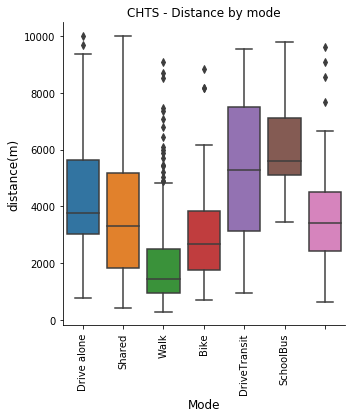

In [73]:
plt.figure(figsize=(10, 6))

sns.catplot(x="trip_mode", y="dist", kind="box", data= df[df.dist < 10000])
plt.xticks([0,1,2,3,4,5,6],['Drive alone','Shared','Walk','Bike','DriveTransit','SchoolBus'], rotation=90)
plt.xlabel('Mode', fontsize = 12)
plt.ylabel('distance(m)', fontsize = 12)
plt.title('CHTS - Distance by mode');

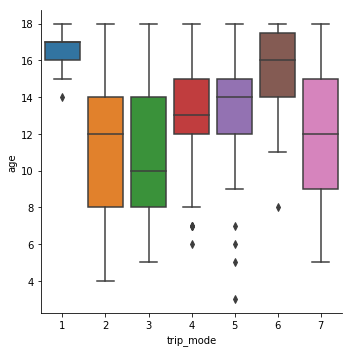

In [98]:
sns.catplot(x="trip_mode", y="age",kind="box", data=df);